# **Clasificación de imágenes de múltiples clases utilizando una red neuronal profunda**
# Materia: Inteligencia Artificial II

* Profesor:  Andrés Hernández  Gutiérrez

Autores:
* Jonathan A. Valadez Saldaña

* Rafael Romero Hurtado 628911

* Isis Ramos Calvillo 632232

Organización: Universidad de Monterrey   

Creado: 08 December 2024 - San Pedro Garza García, N.L.

---
    
        


**Aplicación del mundo real: Identificador de frutas y verduras**

La aplicación seleccionada consiste en un sistema inteligente para identificar frutas y verduras, con múltiples casos de uso en entornos cotidianos y agrícolas. En los supermercados, este sistema puede ser una herramienta clave para evitar pérdidas económicas derivadas de robos o errores en el pesaje de productos. Además, facilita la interacción con la tecnología para personas que no están familiarizadas con sistemas complejos, permitiéndoles simplemente colocar el producto en una báscula, identificarlo automáticamente y generar un ticket de compra.

En el ámbito agrícola, esta solución podría integrarse en vehículos especializados para clasificar y registrar automáticamente los productos recolectados, mejorando la eficiencia y trazabilidad en el proceso de recolección. Implementado principalmente en vehículo autónomos para facilitar el trabajo.

El uso de deep learning permite superar desafíos como la variabilidad en las formas, colores y tamaños de los productos, garantizando un sistema robusto y confiable.








**RETOS ASOCIADOS**
Variaciones en apariencia: Las frutas y verduras cambian en forma, tamaño, color y madurez, lo que puede confundir al modelo.

Iluminación: Las condiciones de luz varían mucho en supermercados afectando cómo se ven los productos.
Ruido en los datos: suciedad en los productos pueden dificultar la identificación.

Clases similares: Algunos productos se parecen mucho, como limones y limas, lo que hace difícil diferenciarlos.

Velocidad: El sistema debe ser rápido para no causar retrasos en supermercados o procesos agrícolas.
*texto en cursiva*
Costo y adaptabilidad: Implementar este sistema debe ser accesible y fácil de actualizar para nuevos productos.


**METODOLOGÍA**

Para el caso de identificar frutas y verduras, la técnica de Redes Neuronales Convolucionales (CNNs) es la más adecuada, ya que están diseñadas para procesar datos visuales, como imágenes, y son excelentes para detectar patrones como formas, colores y texturas.

Adicionalmente, se puede utilizar aprendizaje por transferencia para mejorar los resultados y reducir el tiempo de entrenamiento. Por ejemplo, un modelo preentrenado como ResNet o VGG16 puede adaptarse a tu conjunto de datos de frutas y verduras, lo que permite aprovechar características aprendidas previamente en otros conjuntos de datos de imágenes.

Esto combina lo mejor de ambos enfoques:

CNNs para extraer patrones visuales. Aprendizaje por transferencia para optimizar el rendimiento y el tiempo de desarrollo.

<a name="Implementación-en-Python"></a>
## Python implementation

<a name='Librerías-estándar-requeridas'></a>
### Librerías estándar requeridas


In [1]:
# Import standard libraries
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam  # Cambiar a esta línea
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report  # NUEVO





<a name='deep-neural-network'></a>
### Deep neural network

<a name='Preprocesamiento-del-dataset'></a>
#### Preprocesamiento del dataset


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Tamaño de las imágenes y batch size
IMG_SIZE = (120, 120)
BATCH_SIZE = 32

# Ruta a los datos en Google Drive
TRAIN_DIR = '/content/drive/My Drive/MY_data/train'
PREDICT_DIR = '/content/drive/My Drive/MY_data/predict'

# Generadores para cargar las imágenes ya escaladas
datagen = ImageDataGenerator(
    rescale=1./255,           # Normalización
    validation_split=0.2      # Usar el 20% para validación
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Solo normalización

# Carga de datos para entrenamiento (80%)
train_data = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training',       # Subconjunto de entrenamiento
    seed=123
)

# Conjunto de validación
val_data = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',     # Subconjunto de validación
    shuffle=False,
    seed=123
)

# Conjunto para predicción
predict_data = test_datagen.flow_from_directory(
    PREDICT_DIR,
    target_size=IMG_SIZE,
    batch_size=1,  # Procesamos una imagen a la vez
    class_mode=None,  # No necesitamos etiquetas
    shuffle=False,    # Mantener orden para predecir correctamente
    seed=123
)




Found 1841 images belonging to 10 classes.
Found 460 images belonging to 10 classes.
Found 48 images belonging to 1 classes.


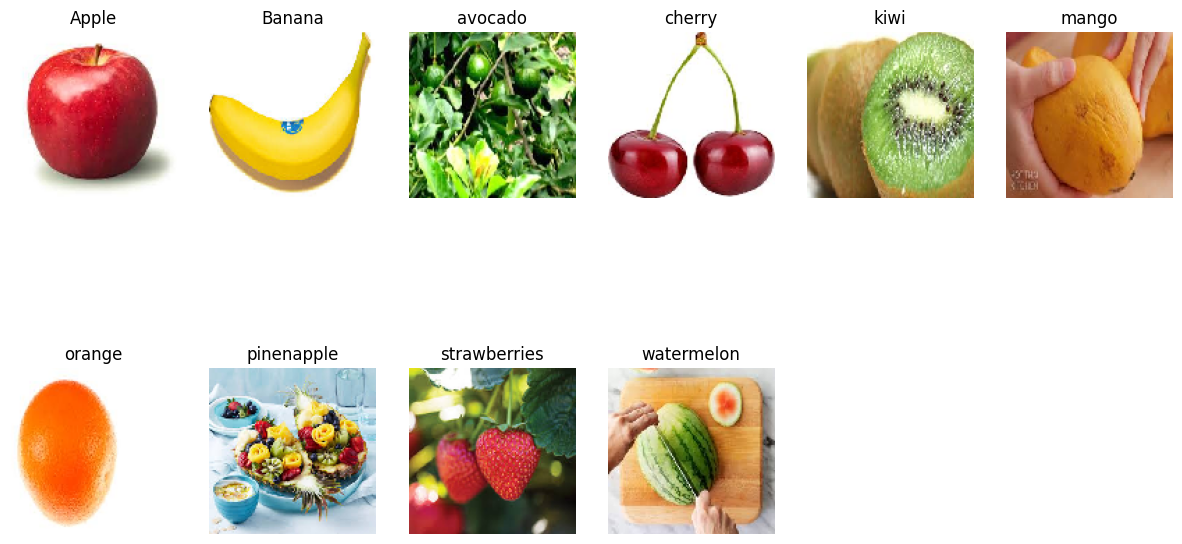

{'Apple': 0, 'Banana': 1, 'avocado': 2, 'cherry': 3, 'kiwi': 4, 'mango': 5, 'orange': 6, 'pinenapple': 7, 'strawberries': 8, 'watermelon': 9}


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Set a global seed for reproducibility
tf.random.set_seed(4500)
np.random.seed(4500)
# Diccionario que contiene las clases detectadas por el generador
class_indices = train_data.class_indices
index_to_class = {v: k for k, v in class_indices.items()}  # Invertir el diccionario

# Crear una figura para mostrar las imágenes
plt.figure(figsize=(15, 8))

# Diccionario para rastrear si ya imprimimos una imagen de cada clase
images_shown = {class_name: False for class_name in class_indices.keys()}

# Recorrer el dataset hasta encontrar una imagen por cada clase
for images, labels in train_data:
    for i in range(len(labels)):
        class_index = np.argmax(labels[i])  # Obtener el índice de la clase
        class_name = index_to_class[class_index]  # Obtener el nombre de la clase

        # Si no hemos mostrado una imagen de esta clase, la mostramos
        if not images_shown[class_name]:
            plt.subplot(2, len(class_indices) // 2 + 1, class_index + 1)
            plt.imshow(images[i])
            plt.title(class_name)
            plt.axis('off')

            # Marcamos que ya mostramos una imagen de esta clase
            images_shown[class_name] = True

        # Si ya tenemos una imagen por cada clase, salimos del loop
        if all(images_shown.values()):
            break
    if all(images_shown.values()):
        break

plt.show()
print(train_data.class_indices)  # Para revisar la distribución de clases


<a name="Diseñando-el-modelo-de-red-neuronal"></a>
### Diseñando el modelo de red neuronal

En este proyecto decidimos probar cuatro modelos diferentes con el fin de encontrar la arquitectura más eficiente y precisa para la clasificación de frutas. Cada modelo presentó variaciones en términos de arquitectura, optimizador, tasa de aprendizaje, y técnicas de regularización, como Dropout y Batch Normalization. Estas modificaciones permitieron explorar el impacto de diferentes estrategias sobre el rendimiento y la capacidad de generalización.

El proceso incluyó la prueba de distintos hiperparámetros, como el uso de los optimizadores SGD y Adam, variaciones en el número de neuronas y capas, así como ajustes en la tasa de aprendizaje. Con cada iteración, buscamos encontrar un balance entre precisión y sobreajuste, seleccionando finalmente el modelo 4 que logró una mayor estabilidad y precisión general del 81.59% en la clasificación de frutas del conjunto de validación.

In [7]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

# Establecer la tasa de aprendizaje
learning_rate = 0.001  # Ajusta esta tasa de aprendizaje según sea necesario
optimizer = Adam(learning_rate=learning_rate)

# Definimos el modelo CNN
model1 = Sequential([
    # Primera capa convolucional
    Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Tercera capa convolucional
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Aplanamiento
    Flatten(),

    # Capas densas
    Dense(128, activation='relu'),
    Dropout(0.5),  # Para prevenir sobreajuste
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Número de clases (ajústalo según tu dataset)
])

# Compilamos el modelo con el optimizador que tiene la tasa de aprendizaje personalizada
model1.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model1.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 118, 118, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 57, 57, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,769,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,871,178 (10.95 MB)

 Trainable params: 2,871,178 (10.95 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:

early_stopping = EarlyStopping(
    monitor='accuracy',  # Monitorea la pérdida de validación
    patience=5,           # Número de épocas sin mejora antes de detener
    restore_best_weights=True,  # Restaura los mejores pesos al final
    verbose=1             # Muestra mensajes durante el entrenamiento
)

history = model1.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stopping],
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 788s 12s/step - accuracy: 0.1020 - loss: 2.3912 - val_accuracy: 0.1978 - val_loss: 2.1989
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.1800 - loss: 2.1671 - val_accuracy: 0.2000 - val_loss: 1.9514
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.1921 - loss: 2.0561 - val_accuracy: 0.2717 - val_loss: 1.8561
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.2462 - loss: 1.9582 - val_accuracy: 0.3109 - val_loss: 1.6968
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.2744 - loss: 1.8548 - val_accuracy: 0.3652 - val_loss: 1.6943
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.2831 - loss: 1.7939 - val_accuracy: 0.3717 - val_loss: 1.6441
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.3015 - loss: 1.7106 - val_accuracy: 0.4304 - val_loss: 1.5293
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.3579 - loss: 1.6501 - val_accuracy: 0.4087 - va

<a name='Entrenamiento-del-modelo'></a>
#### Entrenamiento del modelo

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD

# Establecer la tasa de aprendizaje
optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
loss = CategoricalCrossentropy()

# Definir modelo CNN
model4 = Sequential([
    # Primera capa convolucional
    Conv2D(32, (3, 3), padding='same', input_shape=(120, 120, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Tercera capa convolucional
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Aplanar las características extraídas
    Flatten(),

    # Primera capa densa
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),

    # Segunda capa densa
    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),

    # Capa de salida
    Dense(10, activation='softmax')  # 10 clases (ajusta según tu dataset)
])

# Compilar el modelo
model4.compile(optimizer=optimizer,
               loss=loss,
               metrics=['accuracy'])

# Resumen del modelo
model4.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 120, 120, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 120, 120, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 120, 120, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 60, 60, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 60, 60, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 30, 30, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 30, 30, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,686,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,790,346 (14.46 MB)

 Trainable params: 3,789,514 (14.46 MB)

 Non-trainable params: 832 (3.25 KB)

In [13]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitorea la pérdida de validación
    patience=5,           # Número de épocas sin mejora antes de detener
    restore_best_weights=True,  # Restaura los mejores pesos al final
    verbose=1             # Muestra mensajes durante el entrenamiento
)

history = model4.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
)

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 243ms/step - accuracy: 0.2010 - loss: 2.3982 - val_accuracy: 0.1870 - val_loss: 2.4293
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - accuracy: 0.3805 - loss: 1.7083 - val_accuracy: 0.1370 - val_loss: 2.7101
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.4361 - loss: 1.4991 - val_accuracy: 0.1109 - val_loss: 3.0382
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.5053 - loss: 1.3609 - val_accuracy: 0.1826 - val_loss: 3.2965
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.5424 - loss: 1.2675 - val_accuracy: 0.1630 - val_loss: 3.0923
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.5796 - loss: 1.1754 - val_accuracy: 0.2348 - val_loss: 2.5046
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.5754 - loss: 1.1307 - val_accuracy: 0.2543 - val_loss: 2.4674
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.6056 - loss: 1.0651 - va

In [14]:
model4.save('modelo4.keras')


In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Cargar el modelo VGG16 preentrenado (sin incluir la última capa)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

# Congelar las capas base
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas personalizadas para clasificación
model3 = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Cambia 10 por el número de clases de tu dataset
])

# Compilar el modelo
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model3.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 3, 3, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,305,930 (58.39 MB)

 Trainable params: 591,242 (2.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida de validación
    patience=5,           # Número de épocas sin mejora antes de detener
    restore_best_weights=True,  # Restaura los mejores pesos al final
    verbose=1             # Muestra mensajes durante el entrenamiento
)

history = model3.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 25s 278ms/step - accuracy: 0.2506 - loss: 2.1923 - val_accuracy: 0.5935 - val_loss: 1.3125
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step - accuracy: 0.5499 - loss: 1.3408 - val_accuracy: 0.6717 - val_loss: 1.0901
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.6502 - loss: 1.0550 - val_accuracy: 0.6913 - val_loss: 0.9779
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.7600 - loss: 0.8001 - val_accuracy: 0.6935 - val_loss: 0.9113
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.7615 - loss: 0.7293 - val_accuracy: 0.7239 - val_loss: 0.8647
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.8290 - loss: 0.5824 - val_accuracy: 0.7348 - val_loss: 0.8173
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.8278 - loss: 0.5196 - val_accuracy: 0.7326 - val_loss: 0.8432
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.8698 - loss: 0.4079 - val_accura

In [19]:
model3.save('model3.keras')


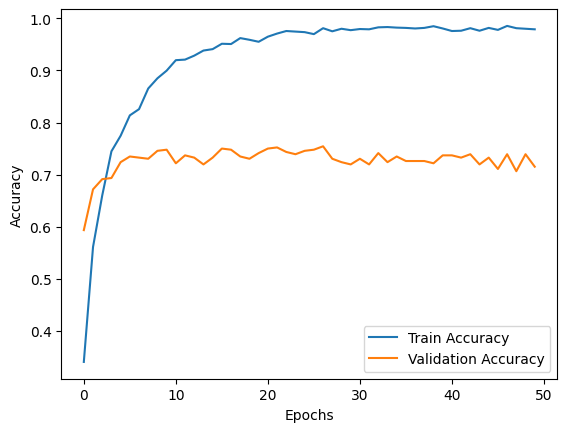

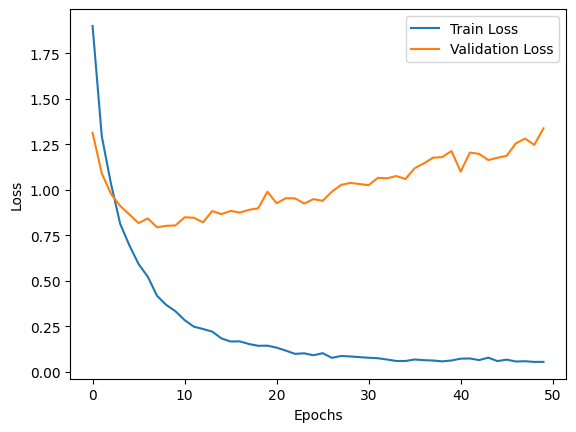

In [20]:
import matplotlib.pyplot as plt

# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [21]:

# Modelo base VGG16 preentrenado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

# Congelar inicialmente todas las capas
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas personalizadas
model5 = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Cambia 10 por el número de clases de tu dataset
])

# Descongelar las últimas 2 capas del modelo base
for layer in base_model.layers[-2:]:
    layer.trainable = True

# Compilar el modelo con SGD
optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model5.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callback de early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model5.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stopping],
)




Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.1868 - loss: 2.3222 - val_accuracy: 0.5152 - val_loss: 1.6855
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.4276 - loss: 1.6630 - val_accuracy: 0.6196 - val_loss: 1.2814
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.5733 - loss: 1.2602 - val_accuracy: 0.6674 - val_loss: 1.0788
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.6920 - loss: 0.9850 - val_accuracy: 0.6891 - val_loss: 0.9675
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.7324 - loss: 0.8569 - val_accuracy: 0.7109 - val_loss: 0.8858
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.7625 - loss: 0.7472 - val_accuracy: 0.7283 - val_loss: 0.8484
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step - accuracy: 0.8079 - loss: 0.6324 - val_accuracy: 0.7478 - val_loss: 0.8027
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.8398 - loss: 0.5117 - val_accuracy

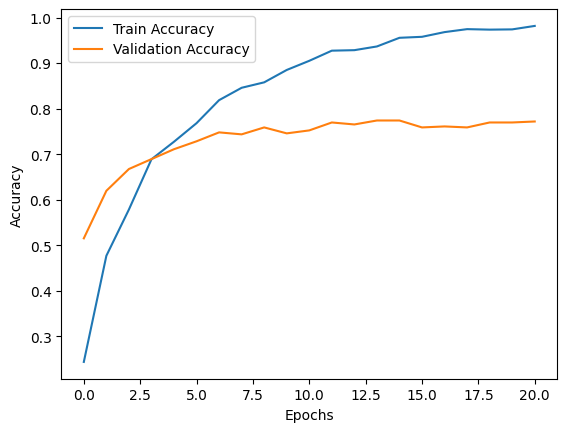

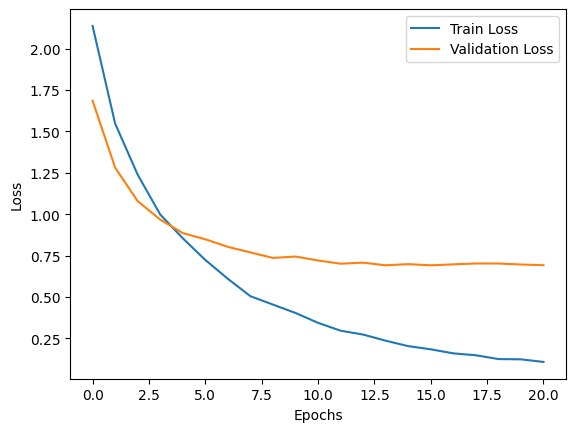

In [22]:
import matplotlib.pyplot as plt

# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [23]:
model5.save('modelo5.keras')


<a name='Evaluación-del-modelo'></a>
#### Evaluación del modelo

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step

Classification Report:
              precision    recall  f1-score   support

       Apple       0.69      0.80      0.74        46
      Banana       0.93      0.85      0.89        46
     avocado       0.77      0.74      0.76        46
      cherry       0.78      0.83      0.80        46
        kiwi       0.75      0.72      0.73        46
       mango       0.60      0.59      0.59        46
      orange       0.57      0.63      0.60        46
  pinenapple       0.90      0.96      0.93        46
strawberries       0.84      0.80      0.82        46
  watermelon       0.82      0.67      0.74        46

    accuracy                           0.76       460
   macro avg       0.76      0.76      0.76       460
weighted avg       0.76      0.76      0.76       460



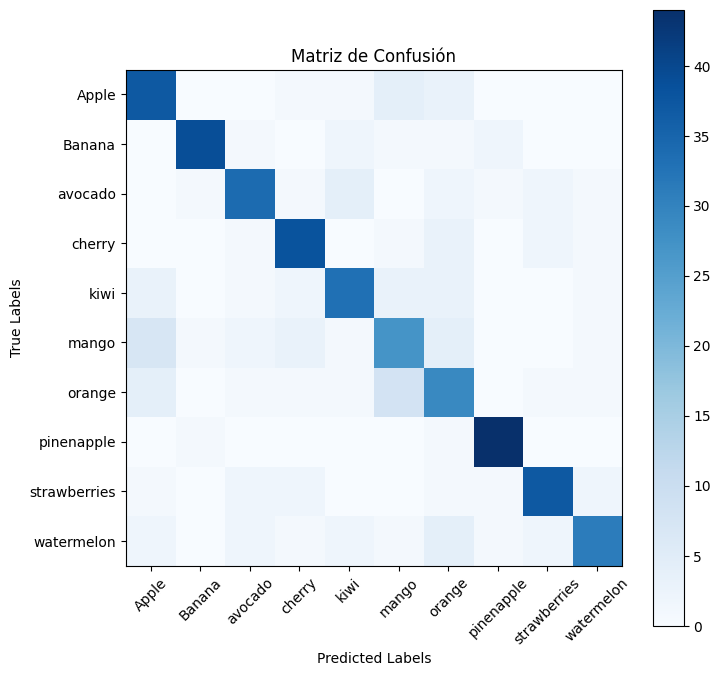

In [16]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model  # Asegúrate de importar esto
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt



model5 = load_model('modelo5.keras')

# Obtener predicciones en el conjunto de validación
predictions = model5.predict(val_data)
predicted_classes = np.argmax(predictions, axis=1)  # Convertir probabilidades a etiquetas
true_classes = val_data.classes  # Etiquetas reales

# Imprimir clasificación y matriz de confusión
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=list(val_data.class_indices.keys())))

# Generar la matriz de confusión
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Mostrar la matriz de confusión usando Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Matriz de Confusión')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(val_data.class_indices)), list(val_data.class_indices.keys()), rotation=45)
plt.yticks(np.arange(len(val_data.class_indices)), list(val_data.class_indices.keys()))
plt.show()

El modelo alcanza una precisión general del 76% en la clasificación de frutas, mostrando un rendimiento consistente en términos de precisión, recall y f1-score. Las clases como "Banana" (f1-score de 0.89) y "Pineapple" (f1-score de 0.93) presentan los mejores resultados, indicando que el modelo identifica estas frutas con alta fiabilidad. Sin embargo, algunas clases como "Mango" (f1-score de 0.59) y "Orange" (f1-score de 0.60) tienen un desempeño más bajo, sugiriendo dificultades para distinguirlas correctamente, posiblemente debido a similitudes visuales o limitaciones en el conjunto de datos. En general, el modelo es adecuado para la mayoría de las categorías, aunque se beneficiarían de ajustes adicionales en el entrenamiento para mejorar su capacidad de generalización en las clases con menor rendimiento.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


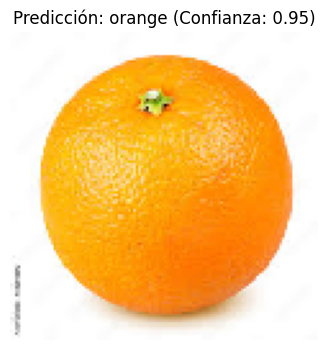

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


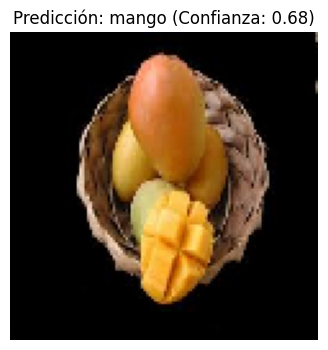

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


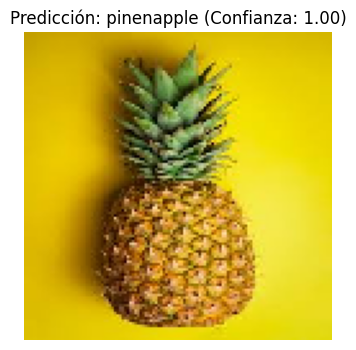

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


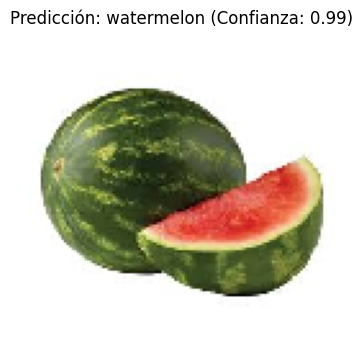

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


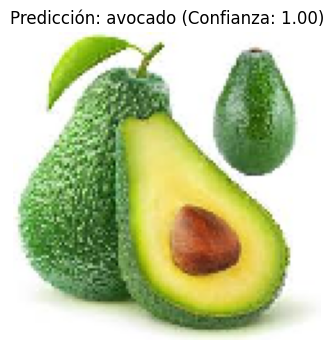

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Obtener el mapeo de índice a nombre de clase
class_indices = train_data.class_indices  # Asumimos que 'train_data' tiene las clases correctas
index_to_class = {v: k for k, v in class_indices.items()}  # Invertimos el diccionario

# Función para mostrar imágenes y predicciones aleatorias
def mostrar_imagenes_y_predicciones(model, data_generator, num_imagenes=5):
    # Obtener las rutas de las imágenes del directorio predict
    filepaths = data_generator.filepaths

    # Seleccionar aleatoriamente las imágenes
    random_indices = np.random.choice(len(filepaths), size=num_imagenes, replace=False)

    # Iterar sobre las imágenes seleccionadas
    for idx in random_indices:
        # Cargar la imagen desde su ruta
        img_path = filepaths[idx]
        img = load_img(img_path, target_size=IMG_SIZE)  # Redimensionamos la imagen
        img_array = img_to_array(img) / 255.0  # Normalizamos entre 0 y 1
        img_array = np.expand_dims(img_array, axis=0)  # Expandimos para formar un batch (1, 120, 120, 3)

        # Hacer la predicción
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)[0]  # Clase con mayor probabilidad
        confidence = np.max(prediction)  # Probabilidad más alta

        # Obtener el nombre de la clase predicha
        class_name = index_to_class[predicted_class]

        # Mostrar la imagen junto con la predicción
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"Predicción: {class_name} (Confianza: {confidence:.2f})")
        plt.axis('off')
        plt.show()

# Llamar a la función para mostrar 5 imágenes aleatorias con sus predicciones
mostrar_imagenes_y_predicciones(model5, predict_data, num_imagenes=5)




```
# Tiene formato de código
```

En esta sección se evalúa el rendimiento del modelo al predecir la clase de fruta en cinco imágenes específicas. El objetivo es verificar si el modelo puede reconocer correctamente las frutas en diferentes condiciones, considerando posibles variaciones en color, forma o iluminación. Como se puede observar en algunos ejemplos es correcta la predicción mientras en otros no. Aunque en la mayaría resulta ser correcto. Como se puede observar predijo de manera correcta las 5 imagenes que se le solicito.

<a name='conclusiones'></a>
## Conclusiones

**Rafael:**

Este proyecto destaca la efectividad de tecnologías avanzadas como el transfer learning y la visión computacional en la implementación de un sistema de clasificación de frutas en tiempo real. El uso de transfer learning permitió aprovechar modelos preentrenados como VGG16, optimizados con datos específicos del dominio, para lograr una predicción precisa sin necesidad de entrenar el modelo desde cero. Esto redujo significativamente el tiempo de desarrollo y los recursos computacionales necesarios.

Además, la integración de técnicas de visión computacional, como el procesamiento de imágenes en tiempo real mediante OpenCV, habilitó la detección y clasificación directa desde una cámara. Este enfoque permitió realizar predicciones en tiempo real y también visualizar y analizar las detecciones de manera interactiva, demostrando el potencial de estas tecnologías para resolver problemas prácticos relacionado con la detección de frutas y verduras.

**Isis:**

El desarrollo de este proyecto a enriquecido mis conocimientos en visión en inteligencia artificial dándome múltiples visones de donde se usa en el día a día . A lo largo del proceso, aprendi a integrar un modelo previamente entrenado con herramientas de procesamiento de imágenes como OpenCV,este ejercicio me permitió comprender el preprocesamiento de datos hasta la visualización de los resultados optenidos.
Este aprendizaje adquirido tiene un valor significativo para mi y para mi futuro ,ya que no solo refuerza conceptos teóricos si no también  en mi formación profesional y en el campo de la ingeniería mecatrónica.


**Jonathan:**

Este proyecto fue muy interesante, ya que se aplicaron muchas cosas de las que se vieron en clase, pero a su vez es un trabajo que requiere de mucho tiempo ya que hay varios factores que pueden afectar al aprendizaje del modelo, ya sea la calidad de los datos, que sean datos insuficientes, o que la arquitectura del modelo no es la adecuada para dicha tarea, y que se tiene que congelar ciertas capas, etc. Es por ello que nos tomó varias pruebas con diferentes versiones del modelo propio e incluso de modelos ya pre-entrenados, sin duda es algo que si se puede mejorar con algo más de tiempo. El tema de visión también estuvo interesando ver cómo a través de la cámara el modelo aún podía identificar algo de lo que aprendió, pero igual la eliminación del fondo es algo que nos quedó por tratar. Independientemente del resultado fue un proyecto muy padre y con varias aplicaciones como en la agricultura en la detección de frutos, en la medicina para identificar anomalías en resonancias, o en la exploración de la vida marina y monitorear especies de ese ambiente, etc.

<a name='referencias'></a>
## Referencias

Abdulnabi, K. (2022). Fruit classification(10 Class). Obtenido de Kaggle: https://www.kaggle.com/datasets/karimabdulnabi/fruit-classification10-class/data

Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.
Chollet, F. (2018). Deep Learning with Python. Manning Publications.
Zhang, Y., & Wallace, B. C. (2017). A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification. arXiv preprint arXiv:1510.03820.

Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556. https://doi.org/10.48550/arXiv.1409.1556